In [203]:
import keras
from keras import layers
from requests import head
from tqdm import tqdm
import tensorflow as tf
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import plot_model, to_categorical
import numpy as np

import matplotlib.pyplot as plt
plt.style.use('ggplot')
from IPython.display import Image, display_png
import pandas as pd
from tensorflow.keras.utils import plot_model

######################################################################################################################
###   CLASS FOR PRE-PROCESSING
######################################################################################################################

class Data:
    def __init__(self, input2id=None, output2id=None):
        self.train_x, self.test_x = [], [] 
        self.train_y, self.test_y = [], []
        self.maxlen_input, self.maxlen_output = 10, 10
        ##### DICT FOR INPUT/OUTPUT <> ID #####
        # if not use custom ID dictionary, this class will make dictionary from received train data
        if input2id == None:
            self.input2id = {'<UNK>':-1,'<PAD>':0,'<SOS>':1,'<EOS>':2} # UNK=unknown, SOS=start of sequence, EOS=end of sequence
        else:
            self.input2id = input2id     
        if output2id == None:
            self.output2id = {'<UNK>':-1,'<PAD>':0, '<SOS>':1,'<EOS>':2}
        else:
            self.output2id = output2id
        self.__inverse_id_input()
        self.__inverse_id_output()
    
    def __inverse_id_input(self):
        self.id2input = {v:k for k,v in self.input2id.items()}
        self.__count_vocab_num()
    def __inverse_id_output(self):
        self.id2output = {v:k for k,v in self.output2id.items()}
        self.__count_vocab_num()

    def __count_vocab_num(self):
        # use in Embedding layer
        self.input_vocab = len(self.input2id)
        self.output_vocab = len(self.output2id)

    ##### SET DATA #####
    def __set_input_train(self, seqs): # seqs: list of list of str  e.g. [['I','eat'],['He','goes']]
        for seq in seqs:
            for token in set(seq) - set(self.input2id.keys()): # only tokens not in dict
                self.input2id[token] = max(self.input2id.values()) + 1 # {'<UNK>':-1,'<PAD>':0,'<SOS>':1,'<EOS>':2} -> next ID is 3
        self.__inverse_id_input()
        self.train_x += seqs

    def __set_output_train(self, seqs): # seqs: list of list of str
        for seq in seqs:
            for token in set(seq) - set(self.output2id.keys()): # only tokens not in dict
                self.output2id[token] = max(self.output2id.values()) + 1 # {'<UNK>':-1,'<PAD>':0,'<SOS>':1,'<EOS>':2} -> next ID is 3
        self.__inverse_id_output()
        self.train_y += seqs

    def __set_input_test(self, seqs):
        self.test_x += seqs

    def __set_output_test(self, seqs):
        self.test_y += seqs

    def set_train(self, train_x, train_y):
        """
        method to setting train data
        make IDs of token automatically
        this method can be called many times to append data
        lengths of train_x and train_y must be equall

        Args:
            train_x: input sequences, list of list of tokens
            train_y: output sequences, list of list of tokens
        """
        assert len(train_x)==len(train_y), ValueError('length of train_x and train_y must be equal')
        self.__set_input_train(train_x)
        self.__set_output_train(train_y)
        self.maxlen_input = max(map(len, train_x)) + 5
        self.maxlen_output = max(map(len, train_y)) + 5

    def set_test(self, test_x, test_y):
        """
        similar to set_train() but it DOES NOT make IDs
        lengths of train_x and train_y must be equall

        Args:
            test_x: input sequences, list of list of tokens
            test_y: output sequences, list of list of tokens
        """
        assert len(test_x)==len(test_y), ValueError('length of test_x and test_y must be equal')
        self.__set_input_test(test_x)
        self.__set_output_test(test_y)

    ##### MAKE INPUT/OUTPUT TENSORS #####
    def make_encoder_input(self, seqs=None):
        if seqs==None:
            seqs = self.train_x
        seqs = [[1]+[self.input2id.get(token, -1) for token in seq]+[2] for seq in seqs] # <sos> + seq + <eos>
        return pad_sequences(seqs, padding='post', maxlen=self.maxlen_input, value=0)

    def make_decoder_input(self, seqs=None):
        if seqs==None:
            seqs = self.train_y
        seqs = [[1]+[self.output2id.get(token, -1) for token in seq] for seq in seqs] # <sos> + seq
        return pad_sequences(seqs, padding='post', maxlen=self.maxlen_output, value=0)

    def make_decoder_output(self, seqs=None):
        if seqs==None:
            seqs = self.train_y
        seqs = [[self.output2id.get(token, -1) for token in seq]+[2] for seq in seqs] # seq + <eos>
        seqs = pad_sequences(seqs, padding='post', maxlen=self.maxlen_output, value=0)
        return to_categorical(seqs, num_classes=self.output_vocab) # one-hot vector

######################################################################################################################
###   CLASS FOR ENCODER / DECODER
######################################################################################################################

class __BaseModel: # only for inheritance
    def build(self):
        raise NotImplementedError('method `bulid` must be implemented in subclass e.g. Encoder') 

    def save(self, filepath):
        model = self.build()
        model.save_weights(filepath)

    def load(self, weight_path):
        self.model = self.build()
        self.model.load_weights(weight_path)

class Encoder(__BaseModel):
    def __init__(self, data:Data, emb_dim=256, lstm_dim=128, lstm_dropout=0.2, return_seq=False): # must return seq when use attention
        self.lstm_dim = lstm_dim
        self.data = data
        ### Layers
        self.input = layers.Input(batch_size=None, shape=(data.maxlen_input,), name='Enc_Input')
        self.embedding = layers.Embedding(input_dim = data.input_vocab, # num of vocab = num of ID dict
                                    input_length = data.maxlen_input,
                                    output_dim = emb_dim,
                                    mask_zero = True,
                                    name = 'Enc_Embedding')
        self.lstm = layers.Bidirectional(layers.LSTM(lstm_dim,
                                        return_sequences=return_seq, # use only final output when w/o attention -> return (batch, lstm_dim)
                                        return_state=True,
                                        recurrent_dropout=lstm_dropout,
                                        name='Enc_LSTM'), name='BiDir') # return: output, h1, c1, h2, c2
        self.concat_h = layers.Concatenate(name='Concat_h') # concatnate bidirectional output of state h 
        self.concat_c = layers.Concatenate(name='Concat_c') # concatnate bidirectional output of state c

    def __call__(self):
        x = self.input
        x = self.embedding(x)
        x, h1, c1, h2, c2 = self.lstm(x)
        h = self.concat_h([h1, h2])
        c = self.concat_c([c1, c2])
        return x, h, c

    def build(self):
        x, h, c = self()
        model = keras.models.Model(inputs=self.input, outputs=[x,h,c])
        return model

class Decoder(__BaseModel):
    def __init__(self, data:Data, emb_dim=256, lstm_dim=256, lstm_dropout=0.2):
        self.lstm_dim = lstm_dim
        self.data = data
        ### Layers
        self.input = layers.Input(batch_size=None, shape=(data.maxlen_output,), name='Dec_Input')
        self.input_h = layers.Input(batch_size=None, shape=(lstm_dim,), name='Dec_Input_h') # for predict
        self.input_c = layers.Input(batch_size=None, shape=(lstm_dim,), name='Dec_Input_c') # for predict
        self.embedding = layers.Embedding(input_dim = data.output_vocab,
                                    input_length = data.maxlen_output,
                                    output_dim = emb_dim,
                                    mask_zero = True,
                                    name = 'Dec_Embedding')
        self.lstm = layers.LSTM(lstm_dim, # twice as lstm dim of encoder
                        return_sequences=True,
                        return_state=True,
                        recurrent_dropout=lstm_dropout,
                        name='Dec_LSTM')
        #self.dense = layers.TimeDistributed(layers.Dense(data.output_vocab, activation='softmax', name='Dec_Hidden'), name='TimeDist')
        self.dense = layers.Dense(data.output_vocab, activation='softmax', name='Dec_Hidden')

        ### for inference - receive previous states
        self.input_h = layers.Input(shape=lstm_dim, name='Dec_Input_h')
        self.input_c = layers.Input(shape=lstm_dim, name='Dec_Input_c')

    def __call__(self, state_h, state_c, enc_output=None):
        x = self.input
        x = self.embedding(x)
        x, h, c = self.lstm(x, initial_state=[state_h, state_c])
        x = self.dense(x)
        return x, h, c

    def build(self):
        output, h, c = self(state_h=self.input_h, state_c=self.input_c)
        model = keras.models.Model(inputs=[self.input, self.input_h, self.input_c], outputs=[output, h, c])
        return model

######################################################################################################################
###   CLASS FOR ATTENTION
######################################################################################################################

class Attention:
    def __init__(self, unit=256, emb_dim=256):
        self.dot = layers.Dot(axes=[2,2], name='Attn_Dot') # (batch, dec_seq_length, "lstm_dim") * (batch, enc_seq_length, "lstm_dim") -> weight (batch, dec_seq_length, enc_seq_length) 
        #self.sqrt = layers.Lambda(lambda x: x/emb_dim**0.5, name='Sqrt') # scaling by square root : */√dim
        self.softmax = layers.Activation(activation='softmax', name='Attn_Softmax')
        self.context = layers.Dot(axes=[2,1], name='Attn_Context') # weight (batch, dec_seq_length, "enc_seq_length") * (batch, "enc_seq_length", dim) -> (batch, dec_seq_length, dim)
        self.concat = layers.Concatenate(name='Attn_Concat') # concate context and decoder output
        self.hidden = layers.Dense(unit, activation='tanh', name='Attn_hidden')

    def __call__(self, enc_output, dec_output):
        attention_dot = self.dot([dec_output, enc_output])
        #attention_weight = self.softmax(self.sqrt(attention_dot))
        attention_weight = self.softmax(attention_dot)
        context_vector = self.context([attention_weight, enc_output])
        concat_vector = self.concat([context_vector, dec_output])
        return self.hidden(concat_vector)

class AttentionDecoder(Decoder):
    def __init__(self, data:Data, emb_dim=256, lstm_dim=256, lstm_dropout=0.2, attention_dim=256):
        super().__init__(data=data, emb_dim=emb_dim, lstm_dim=lstm_dim, lstm_dropout=lstm_dropout)
        self.attention = Attention(unit=attention_dim, emb_dim=emb_dim)
        self.enc_output = layers.Input(batch_size=None, shape=(lstm_dim), name='Enc_Output')
    
    def __call__(self, state_h, state_c, enc_output=None):
        x = self.input
        x = self.embedding(x)
        dec_output, h, c = self.lstm(x, initial_state=[state_h, state_c])
        x = self.attention(enc_output, dec_output)
        x = self.dense(x)
        return x, h, c

    def build(self):
        output, h, c = self(state_h=self.input_h, state_c=self.input_c, enc_output=self.enc_output)
        model = keras.models.Model(inputs=[self.input, self.enc_output, self.input_h, self.input_c], outputs=[output, h, c])
        return model

######################################################################################################################
###   CLASS FOR SEQ2SEQ
######################################################################################################################

class Seq2Seq(__BaseModel):
    def __init__(self, data:Data, emb_dim=256, lstm_dim=128, lstm_dropout=0.2, attention=False, attention_dim=256):
        if not attention:
            self.encoder = Encoder(data=data, emb_dim=emb_dim, lstm_dim=lstm_dim, lstm_dropout=lstm_dropout, return_seq=False)
            self.decoder = Decoder(data=data, emb_dim=emb_dim, lstm_dim=lstm_dim*2, lstm_dropout=lstm_dropout)
        else:
            self.encoder = Encoder(data=data, emb_dim=emb_dim, lstm_dim=lstm_dim, lstm_dropout=lstm_dropout, return_seq=True)
            self.decoder = AttentionDecoder(data=data, emb_dim=emb_dim, lstm_dim=lstm_dim*2, lstm_dropout=lstm_dropout, attention_dim=attention_dim)
        self.data = data
        self.input_x, self.input_y, self.output_y = [], [], [] # use for train
        self.history = None
        self.is_attention = attention
    
    def build(self, show_summary=True, opt='rmsprop', loss='categorical_crossentropy'):
        ### MODEL FOR TRAIN ###
        enc_output, enc_h, enc_c = self.encoder() # if w/o attention, discard enc_output, use only state
        if not self.is_attention:
            dec_output, dec_h, dec_c = self.decoder(state_h=enc_h, state_c=enc_c)
        else:
            dec_output, dec_h, dec_c = self.decoder(state_h=enc_h, state_c=enc_c, enc_output=enc_output)

        self.model = keras.models.Model(inputs=[self.encoder.input, self.decoder.input], outputs=dec_output)
        self.model.compile(optimizer=opt, loss=loss, metrics='accuracy')
        
        if show_summary:
            print(self.model.summary())

        ### ENCODER MODEL FOR PREDICT ###
        self.encoder_pred = keras.models.Model(self.encoder.input, [enc_output, enc_h, enc_c]) # if w/o attention, discard enc_output, use only state

        ### DECODER MODEL FOR PREDICT ###
        x = self.decoder.embedding(self.decoder.input)
        x, h, c = self.decoder.lstm(x, initial_state=[self.decoder.input_h, self.decoder.input_c])
        if self.is_attention:
            x = self.decoder.attention(enc_output, x)
            x = self.decoder.dense(x)
            self.decoder_pred = keras.models.Model(
                                inputs=[self.decoder.input, self.decoder.input_h, self.decoder.input_c, enc_output],
                                outputs=[x, h, c])
        else:
            x = self.decoder.dense(x)
            self.decoder_pred = keras.models.Model(
                                inputs=[self.decoder.input, self.decoder.input_h, self.decoder.input_c],
                                outputs=[x, h, c])
        return self.model

    def summary(self):
        self.model.summary()

    def show_model(self):
        plot_model(self.model, show_shapes=True,to_file='model.png')
        display_png(Image('model.png'))
    
    def train(self, batch_size=100, epoch=20, dev_split=0.2):
        if len(self.input_x) == 0:
            self.input_x = self.data.make_encoder_input()
            self.input_y = self.data.make_decoder_input() 
            self.output_y = self.data.make_decoder_output()
        history = self.model.fit([self.input_x, self.input_y], self.output_y,
                            batch_size=batch_size,
                            epochs=epoch,
                            validation_split=dev_split)
        if self.history == None:
            self.history = history.history
        else:
            self.history = {k: v+history.history[k] for k,v in self.history.items()}
        self.show_history()

    def show_history(self):
        return pd.DataFrame(self.history).plot(xlabel='Epoch')

    def predict_one(self, input_seq:list, join_by=None, is_beam=False, beam_return_all=True, beam_depth=3):
        if type(input_seq[0]) == str:
            input_seq = [input_seq] # input must be 2D
        input_seq = self.data.make_encoder_input(input_seq) # convert to ID
        enc_output, h, c = self.encoder_pred.predict(input_seq, verbose=0) # verbose=0: not print
        target_seq = np.zeros((1, self.data.maxlen_output)) # generate target seq of length 1 e.g. [[5,0,0,0,0,...]]
        target_seq[0,0] = 1 # <sos> ID=1

        # Sampling loop for a batch of sequences
        def get_next_output(target_seq, h_old, c_old):
            if self.is_attention:
                output_ids, h_new, c_new = self.decoder_pred.predict([target_seq, h_old, c_old, enc_output], verbose=0) # not print
            else:
                output_ids, h_new, c_new = self.decoder_pred.predict([target_seq, h_old, c_old], verbose=0) # not print
            return output_ids, h_new, c_new

        # if greedy search, sampled_seq is list of index  e.g. [5,3,2,...]
        # if beam search, sampled_seq is [[list of index, ΣlogP, h, c], [list of index, ΣlogP, h, c],...]
        stop_condition = False
        sampled_seq = []
        
        while not stop_condition:

            ### sampling for greedy search ###
            if not is_beam:
                output_ids, h, c = get_next_output(target_seq, h, c) # h, c are overwrited
                sampled_id= np.argmax(output_ids[0, -1, :])
                
                if (sampled_id == 2 or len(sampled_seq) > self.data.maxlen_output): # stop if <eos>=2
                    stop_condition = True
                else:
                    sampled_seq.append(sampled_id)
                target_seq = np.zeros((1, self.data.maxlen_output)) # update the target sequence (of length 1).
                target_seq[0, 0] = sampled_id 

            ### sampling for beam search ###
            # get both argmaxs and probs
            else:
                if len(sampled_seq) == 0: # first token
                    output_ids, h, c = get_next_output(target_seq, h, c) # h, c are overwrited
                    sampled_ids= np.argpartition(output_ids[0, -1, :], -beam_depth)[-beam_depth:] # args of 3 max values
                    probs = output_ids[0, -1, :][sampled_ids]
                    sampled_seq = [[[i], np.log(prob), h, c] for i, prob in zip(sampled_ids, probs)]
                else:
                    if all([x[0][-1]==2 for x in sampled_seq]) or all([len(x[0]) >= self.data.maxlen_output for x in sampled_seq]): # if all 3 seq end with <eos>=2
                        break
                    candidates = [] # beam_depth*beam_depth candidates
                    for seq_now, prob_now, h_now, c_now in sampled_seq: # e.g. [[3,10,4], ΣlogP, h, c]
                        if seq_now[-1]==2: # if ends with <eos>, add to candidates and skip
                            candidates.append([seq_now, prob_now, h_now, c_now])
                            continue
                        target_seq = np.zeros((1, self.data.maxlen_output))
                        target_seq[0, 0] = seq_now[-1] # the last id
                        output_ids, h, c = get_next_output(target_seq, h_now, c_now)
                        sampled_ids= np.argpartition(output_ids[0, -1, :], -beam_depth)[-beam_depth:] # args of 3 max values
                        probs = output_ids[0, -1, :][sampled_ids]
                        candidates += [[seq_now+[i], prob_now+np.log(prob), h, c] for i, prob in zip(sampled_ids, probs)]
                    sampled_seq = sorted(candidates, key=lambda x: x[1], reverse=True)[:beam_depth] # only 3 max prob
                    #print([x[:2] for x in sampled_seq])
        
        ### Decode ###
        def decode_sample(sampled_seq, join_by):
            decoded_seq = [self.data.id2output.get(sampled_id, -1) for sampled_id in sampled_seq]
            if type(join_by)==str:
                decoded_seq = join_by.join(decoded_seq)
            return decoded_seq

        if is_beam:
            sampled_seq = [x[0] for x in sampled_seq] # take only list of index
            sampled_seq = [x[:-1] if x[-1]==2 else x for x in sampled_seq] # if endswith <eos>=2, remove it
            if beam_return_all:
                return [decode_sample(x, join_by=join_by) for x in sampled_seq] # return all candidates
            else:
                sampled_seq = sampled_seq[0] # take only max prob one
                return decode_sample(sampled_seq, join_by=join_by)
        else:
            return decode_sample(sampled_seq, join_by=join_by)

    def predict(self, seqs=None, join_by=None, is_beam=False, beam_return_all=True, beam_depth=3):
        if seqs == None:
            seqs = self.data.test_x
        decoded = []
        for seq in tqdm(seqs):
            decoded.append(self.predict_one(seq, join_by=join_by, is_beam=is_beam, beam_return_all=beam_return_all, beam_depth=beam_depth))
        return decoded

######################################################################################################################
###   CLASS FOR TRANSFORMER
######################################################################################################################

class PositionalEncoding(__BaseModel):
    def __init__(self, seq_len, output_dim=128, n=1000):
        self.seq_len = seq_len
        self.output_dim = output_dim
        self.n = n

    def __call__(self):
        P = np.zeros((self.seq_len, self.output_dim))
        for k in range(self.seq_len):
            for i in np.arange(int(self.output_dim/2)):
                denominator = np.power(self.n, 2*i/self.output_dim)
                P[k, 2*i] = np.sin(k/denominator)
                P[k, 2*i+1] = np.cos(k/denominator)
        return P


class SingleTransformer(__BaseModel):
    def __init__(self, data, emb_dim=256, hidden_dim=128, head_num=4, dropout_rate=0.2):
        self.data = data
        self.seq_len = data.maxlen_input
        self.emb_dim = emb_dim
        self.hidden_dim = hidden_dim
        self.head_num = head_num
        assert emb_dim % head_num == 0, ValueError('emb_dim must be multiple of head_num')
        ### LAYERS ###
        self.input = layers.Input(batch_size=None, shape=(self.seq_len, emb_dim), name='Input') # input must be (batch, seq_len, emb_dim)
        self.split = layers.Lambda(self._split_head, output_shape=(head_num, self.seq_len, emb_dim//head_num), name='Split_Head') # (batch, seq_len, emb_dim) -> (batch, head_num, seq_len Q, emb_dim//head_num)
        self.Q = layers.Dense(hidden_dim, activation='relu', name='Query') # (batch, head_num, seq_len, emb_dim) -> (batch, head_num, seq_len, hidden_dim)
        self.K = layers.Dense(hidden_dim, activation='relu', name='Key')
        self.V = layers.Dense(hidden_dim, activation='relu', name='Value')
        self.sqrt = layers.Lambda(lambda x: x/hidden_dim**0.5, name='Sqrt') # scaling by square root : */√dim
        self.softmax = layers.Activation(activation='softmax', name='Softmax') # weight
        self.dropout = layers.Dropout(dropout_rate, name='Dropout')
        #self.concat_Q = layers.Concatenate(name='Concat_Query') # concate context and value (batch, seq_len, dim*2)     
        self.combine = layers.Lambda(self._combine_head, output_shape=(self.seq_len, hidden_dim*head_num), name='Combine_Head') # (batch, head_num, seq_len, dim) -> (batch, seq_len, dim*head_num)
        self.output_hidden = layers.Dense(emb_dim, activation='relu',name='Output_hidden') # (batch, seq_len, emb_dim)
        self.normalize = layers.BatchNormalization(name='normalize')

    def _split_head(self, input_tensor):
        '''
        split input embbeding into multi head
        input shape: (batch, seq_len, emb_dim) -> output shape: (batch, head_num, seq_len, emb_dim//head_num)
        '''
        batch_size, seq_length, emb_dim = tf.unstack(tf.shape(input_tensor))
        input_tensor = tf.reshape(input_tensor, [batch_size, self.seq_len, self.head_num, self.emb_dim // self.head_num])
        return tf.transpose(input_tensor, [0, 2, 1, 3])

    def _combine_head(self, input_tensor):
        '''
        combine output of multi head
        input shape: (batch, head_num, seq_len, emb_dim//head_num) -> output shape: (batch, seq_len, emb_dim)
        '''
        batch_size, head_num, seq_length, splitted_dim = tf.unstack(tf.shape(input_tensor))
        input_tensor = tf.transpose(input_tensor, [0, 2, 1, 3])
        print(input_tensor)
        return tf.reshape(input_tensor, [batch_size, self.seq_len, self.hidden_dim])

    def __call__(self): 
        input_tensor = self.input 
        splitted = self.split(input_tensor) # (batch, seq_len Q, emb_dim) -> (batch, head_num, seq_len Q, emb_dim)
        Q, K, V = self.Q(splitted), self.K(splitted), self.V(splitted) # (batch, head_num, seq_len Q, emb_dim) -> (batch, head_num, seq_len Q, hidden_dim)
        dot_QK = tf.matmul(Q, K, transpose_b=True, name='Dot_QK') # (batch, head_num, seq_lenQ, dim) * (batch, head_num, seq_lenK, dim) -> weight (batch, head_num, seq_lenQ, seq_lenK) 
        weight = self.dropout(self.softmax(self.sqrt(dot_QK))) # scaling & softmax
        context = tf.matmul(weight, V, transpose_b=False, name='Dot_Value') # (batch, head_num, seq_lenQ, seq_lenK) * (batch, head_num, seq_lenV, dim) -> context (batch, head_num, seq_len, dim)
        #context = self.concat_Q([context, Q])
        output = self.output_hidden(self.combine(context)) # (batch, head_num, seq_len, dim) -> (batch, seq_len, dim*head_num)
        return self.normalize(output)

    def build(self):
        output = self()
        model = keras.models.Model(self.input, output)
        return model

class Transformers(__BaseModel):
    def __init__(self, data, repeat=3, emb_dim=256, hidden_dim=256, head_num=4, dropout_rate=0.2):
        self.data = data
        self.seq_len = data.maxlen_input
        self.emb_dim = emb_dim
        self.hidden_dim = hidden_dim
        self.head_num = head_num
        self.trans = [SingleTransformer(data, emb_dim=emb_dim, hidden_dim=hidden_dim, head_num=head_num, dropout_rate=dropout_rate) for _ in range(repeat)]
        self.position = PositionalEncoding()

In [204]:
### load data
train_x = open('../data/train_x.txt').read().splitlines()
train_y = open('../data/train_y.txt').read().splitlines()
#test_x = open('data/test_x.txt').read().splitlines()
#test_y = open('data/test_y.txt').read().splitlines()

### Instantiation
data = Data()
data.set_train(train_x, train_y)
#data.set_test(test_x, test_y)

In [205]:
inst = SingleTransformer(data)

In [210]:
p = PositionalEncoding(19)
a = tf.constant(np.ones([2,3,4]))
x = p()
x.shape

(19, 128)

In [200]:
p

In [191]:
model = inst.build()

Tensor("Combine_Head/transpose:0", shape=(None, 19, 4, 128), dtype=float32)


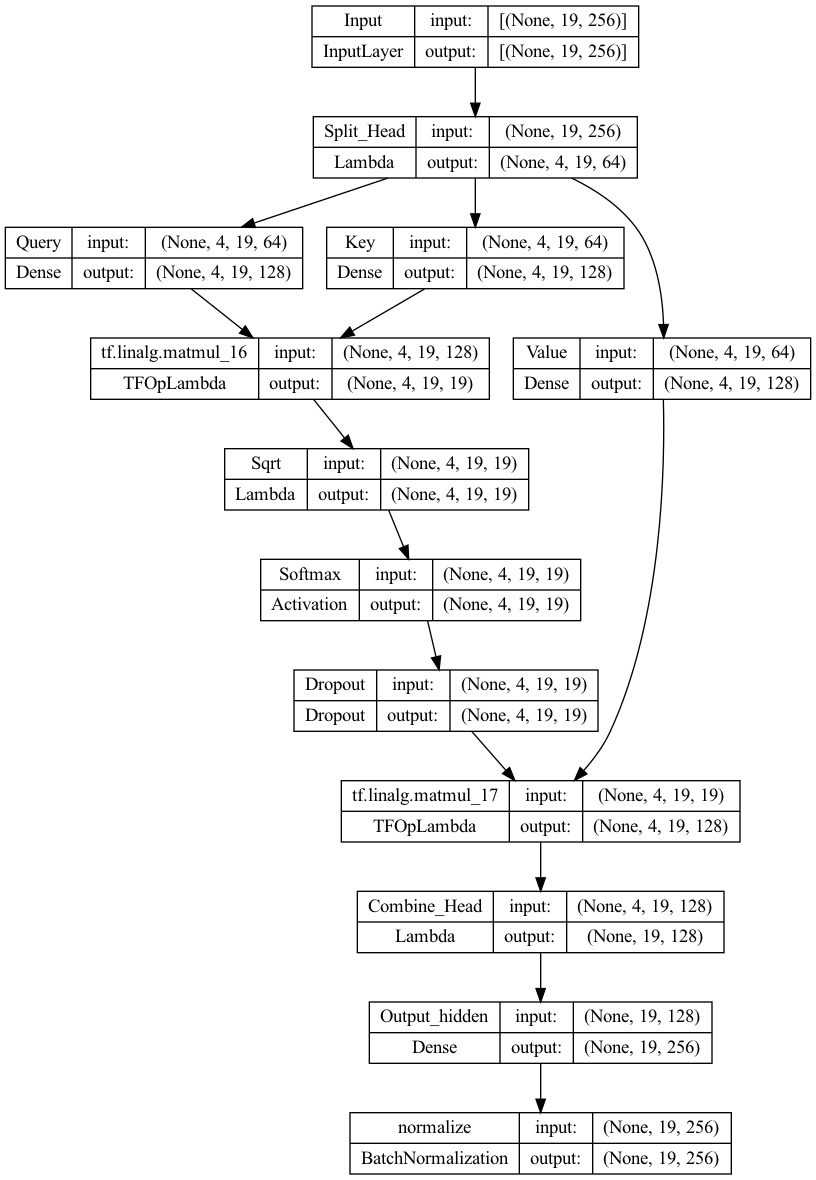

In [192]:
plot_model(model, show_shapes=True,to_file='model.png')
display_png(Image('model.png'))